#Section **3**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("ddos_dataset.csv",index_col=[0])
df["Flow ID"] = df[" Source IP"].astype(str)+"-"+df[" Destination IP"].astype(str)+"-"+df[" Source Port"].astype(str)+"-"+df[" Destination Port"].astype(str)+"-"+df[" Protocol"].astype(str)

df_processing = df.copy()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'Category' column
df_processing['label'] = label_encoder.fit_transform(df_processing['label'])


columns=["Protocol_0","Protocol_6","Protocol_17"]
encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(df_processing[[' Protocol']])
one_hot_encoded_array = one_hot_encoded.toarray()
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_array, columns=columns,index=df.index)
df_processing = pd.concat([df_processing, one_hot_encoded_df], axis=1)

column_to_move = 'label'
new_position = df_processing.columns.size-1
column_pop = df_processing.pop(column_to_move)

# Insert the column at the new position
df_processing.insert(new_position, column_to_move, column_pop)

df_copy = df_processing.copy()

def isMostFrequent(port,par):
     if par==1:
      return not(port in most_frequent_source_ports)
     else:
      return not(port in most_frequent_destination_ports)

most_frequent_source_ports = df_copy[" Source Port"].value_counts()[:10].index
most_frequent_destination_ports = df_copy[" Destination Port"].value_counts()[:5].index

print("Most Frequent Source Ports:")
print(most_frequent_source_ports)

mask = [ isMostFrequent(i,1) for i in df_copy[" Source Port"].values ]
df_copy.loc[mask," Source Port"] = -1

print(df_copy[" Source Port"].unique())

df_copy = pd.get_dummies(df_copy, columns=[' Source Port'])

df_encoded = df_copy.copy()

# most_frequent_destination_ports = df_encoded[" Destination Port"].value_counts()[:5].index
print("Most Frequent Destination Ports:")
print(most_frequent_destination_ports)

mask = [ isMostFrequent(i,0) for i in df_encoded[" Destination Port"].values ]
df_encoded.loc[mask," Destination Port"] = -1

print(df_encoded[" Destination Port"].unique())

df_encoded = pd.get_dummies(df_encoded, columns=[' Destination Port'])

column_to_move = 'label'
new_position = df_encoded.columns.size-1
column_pop = df_encoded.pop(column_to_move)

# Insert the column at the new position
df_encoded.insert(new_position, column_to_move, column_pop)
df_encoded

df_processed = df_encoded.drop([' Source IP', ' Destination IP', ' Timestamp','Flow ID','SimillarHTTP',' Protocol'], axis=1)
df_processed

# df_processed presenta un one hot encoding per i protocolli, per le 10 Source Port più usate, per le 5 Destination Port più usate
# e rimuove gli ip src e dest, timestamp, flow ID, SimillarHTTP e Protocol (src port e dest port sono rimosse dalla funzione get_dummies)
# e infine vi è un label encoding per gli attacchi

In [ ]:
X = df_processed.drop(columns=['label']) # 99 è label
Y = df_processed['label']

In [ ]:
scaler = StandardScaler()
Xs = X.copy()
for col in X.columns:

    # fit the scaler on the data
    scaler.fit(Xs[col].values.reshape(-1, 1))

    # transform the data
    Xs[col] = scaler.transform(Xs[col].values.reshape(-1, 1))


In [ ]:
correlation_matrix = Xs.corr().abs()

In [ ]:
#correlation analysis
c = correlation_matrix
so = c.unstack().reset_index()

aa = pd.DataFrame(so)
aa['sum'] = 0
# Get strongly correlatead features, removing pairs having correlation = 1 because of the diagonal, i.e., correlation between one feature and itself
aa = aa[(aa[0].isnull()==False) & (aa["level_0"] != aa["level_1"])]

for col in correlation_matrix.columns:
    mask = aa['level_0'] == col
    aa['sum'].loc[mask]=(aa[0].loc[mask]**2).sum()


aa = aa.sort_values([0,'sum'], ascending = False)
print(aa)
# Extract features having a correlation > 0.8
aa = aa[aa[0]>0.8]


# Get the unique set of features to be saved and the set to be deleted
to_be_saved = []
to_be_deleted = []

savedCandidates = list(aa["level_0"])
toBeDeletedCandidates = list(aa['level_1'])

# Notice that we discard one feature per time considering the case where a feature is strongly correlated with multiple features
subset_so = aa.copy()
for sav,tbd in zip(savedCandidates,toBeDeletedCandidates):
    if(sav not in to_be_deleted):
        if(sav in to_be_saved and tbd in to_be_saved):
            to_be_deleted.append(tbd)
            to_be_saved.remove(tbd)
            subset_so = subset_so[(subset_so["level_0"] != tbd) & (subset_so["level_1"] != tbd)] # remove the rows that the removed feature is involved
        elif(sav in to_be_saved):
            to_be_deleted.append(tbd)
            subset_so = subset_so[(subset_so["level_0"] != tbd) & (subset_so["level_1"] != tbd)] # remove the rows that the removed feature is involved
        elif (tbd in to_be_saved): #if the candidate was saved before we cannot eliminate it in the future
            to_be_deleted.append(sav)
            subset_so = subset_so[(subset_so["level_0"] != sav) & (subset_so["level_1"] != sav)] # remove the rows that the removed feature is involved
        else:
            to_be_deleted.append(tbd)
            to_be_saved.append(sav) # add the feature to the removed candidates
            subset_so = subset_so[(subset_so["level_0"] != tbd) & (subset_so["level_1"] != tbd)] # remove the rows that the removed feature is involved
to_be_deleted = set(to_be_deleted)
to_be_saved = set(to_be_saved)

In [ ]:
Xs = Xs.drop(columns = to_be_deleted)
## Ora rimuoviamo le righe null nella Correlation Matrix

rows_to_be_deleted = correlation_matrix[" Total Fwd Packets"].isnull()
to_be_dropped = rows_to_be_deleted.loc[rows_to_be_deleted == True].index
Xs = Xs.drop(columns=to_be_dropped)
Xs.columns.size

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score

In [ ]:
y = Y.values

In [ ]:
#first of all we try to see what happens with a number of clusters equal to the number of labels
gmm = GaussianMixture(n_components=12)
cl_labels3 = gmm.fit_predict(Xs) # Get clusters ID

# Unsupervised metric
silhouette  = silhouette_score(Xs, cl_labels3)
log_l=gmm.score(Xs)
# Supervised metrics
ri = rand_score(np.ravel(y), cl_labels3)
ari = adjusted_rand_score(np.ravel(y), cl_labels3)


# report effective size
print("Effetive size of each cluster: ", gmm.weights_)
# report usupervised and supervised metric
print(f'GMM total log-likelihood score:, {round(log_l, 2)}')
print(f'Silhouette: {round(silhouette, 2)}')
print(f'RI: {round(ri, 2)}')
print(f'ARI: {round(ari, 2)}')

## Determine the number of clusters

  0%|          | 0/12 [00:00<?, ?it/s]

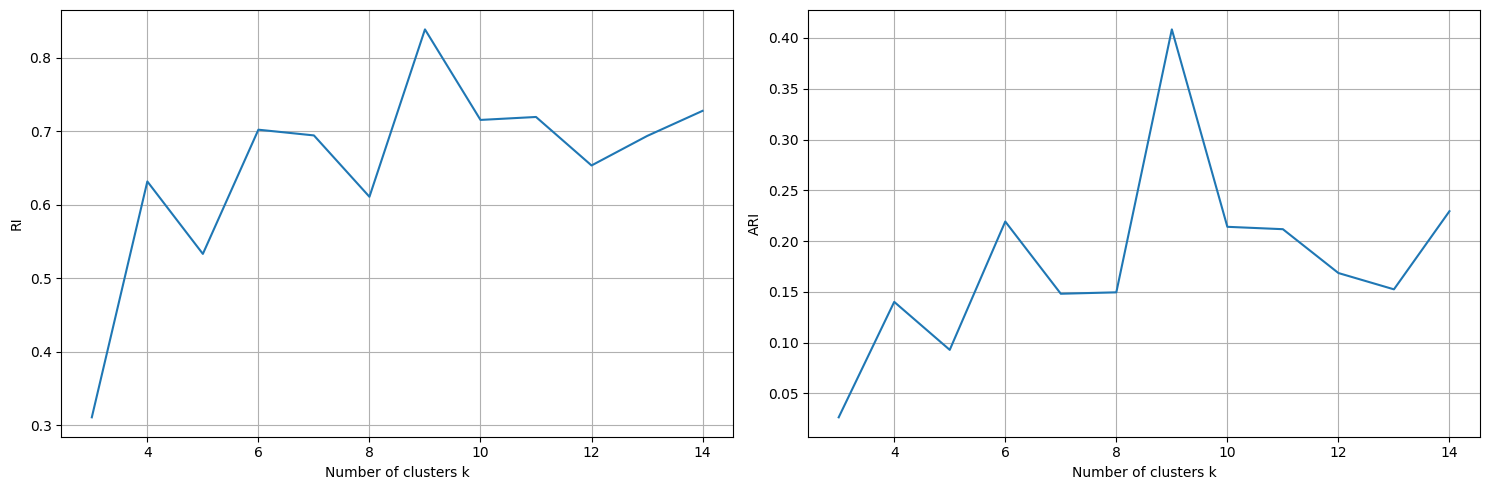

In [ ]:
n_cluster_list = []
ri_list = []
ari_list = []
from tqdm.notebook import tqdm
for n_clusters in tqdm(range(3, 15)):
    gmm = GaussianMixture(n_components=n_clusters)
    cl_labels = gmm.fit_predict(Xs)
    ari  = adjusted_rand_score(np.ravel(y), cl_labels)
    n_cluster_list.append(n_clusters)
    ari_list.append(ari)
    ri_list.append(rand_score(np.ravel(y), cl_labels))
fig, axs = plt.subplots(1,2, figsize=(15, 5))

axs[0].plot(
    n_cluster_list,
    ri_list
)
axs[0].set_xlabel("Number of clusters k")
axs[0].set_ylabel("RI")
axs[0].grid()

axs[1].plot(
    n_cluster_list,
    ari_list
)
axs[1].set_xlabel("Number of clusters k")
axs[1].set_ylabel("ARI")
axs[1].grid()

plt.tight_layout()
plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

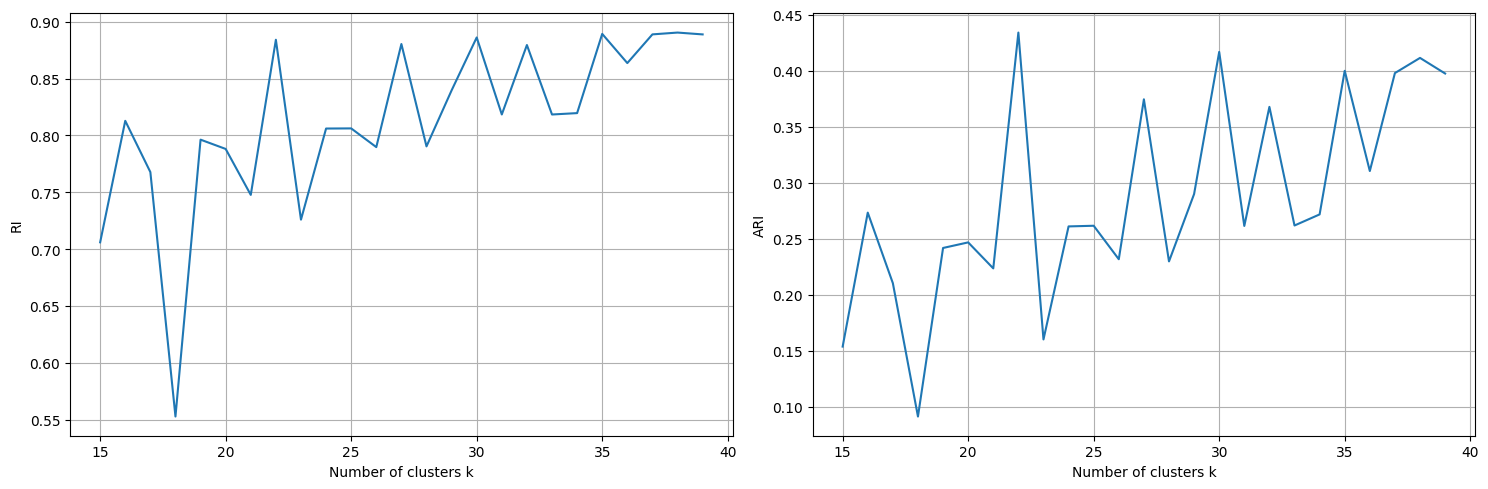

In [ ]:
n_cluster_list = []
ri_list = []
ari_list = []
from tqdm.notebook import tqdm
for n_clusters in tqdm(range(15, 40)):
    gmm = GaussianMixture(n_components=n_clusters)
    cl_labels = gmm.fit_predict(Xs)
    ari  = adjusted_rand_score(np.ravel(y), cl_labels)
    n_cluster_list.append(n_clusters)
    ari_list.append(ari)
    ri_list.append(rand_score(np.ravel(y), cl_labels))
fig, axs = plt.subplots(1,2, figsize=(15, 5))

axs[0].plot(
    n_cluster_list,
    ri_list
)
axs[0].set_xlabel("Number of clusters k")
axs[0].set_ylabel("RI")
axs[0].grid()

axs[1].plot(
    n_cluster_list,
    ari_list
)
axs[1].set_xlabel("Number of clusters k")
axs[1].set_ylabel("ARI")
axs[1].grid()

plt.tight_layout()
plt.show()

  0%|          | 0/35 [00:00<?, ?it/s]

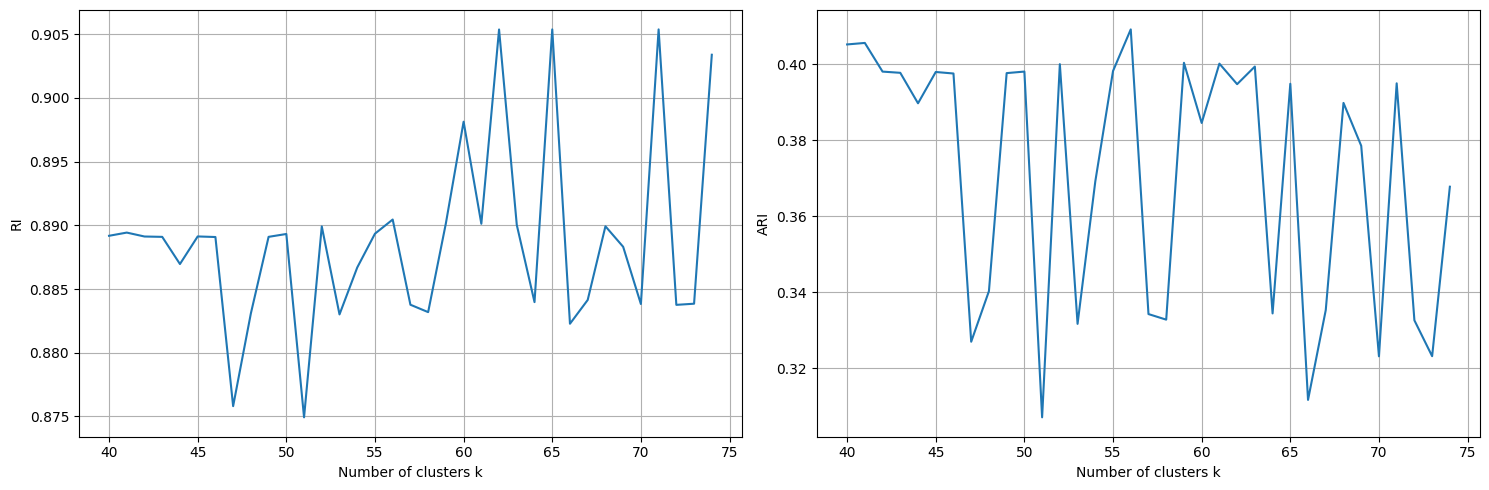

In [ ]:
n_cluster_list = []
ri_list = []
ari_list = []
from tqdm.notebook import tqdm
for n_clusters in tqdm(range(40, 75)):
    gmm = GaussianMixture(n_components=n_clusters)
    cl_labels = gmm.fit_predict(Xs)
    ari  = adjusted_rand_score(np.ravel(y), cl_labels)
    n_cluster_list.append(n_clusters)
    ari_list.append(ari)
    ri_list.append(rand_score(np.ravel(y), cl_labels))
fig, axs = plt.subplots(1,2, figsize=(15, 5))

axs[0].plot(
    n_cluster_list,
    ri_list
)
axs[0].set_xlabel("Number of clusters k")
axs[0].set_ylabel("RI")
axs[0].grid()

axs[1].plot(
    n_cluster_list,
    ari_list
)
axs[1].set_xlabel("Number of clusters k")
axs[1].set_ylabel("ARI")
axs[1].grid()

plt.tight_layout()
plt.show()

  0%|          | 0/12 [00:00<?, ?it/s]

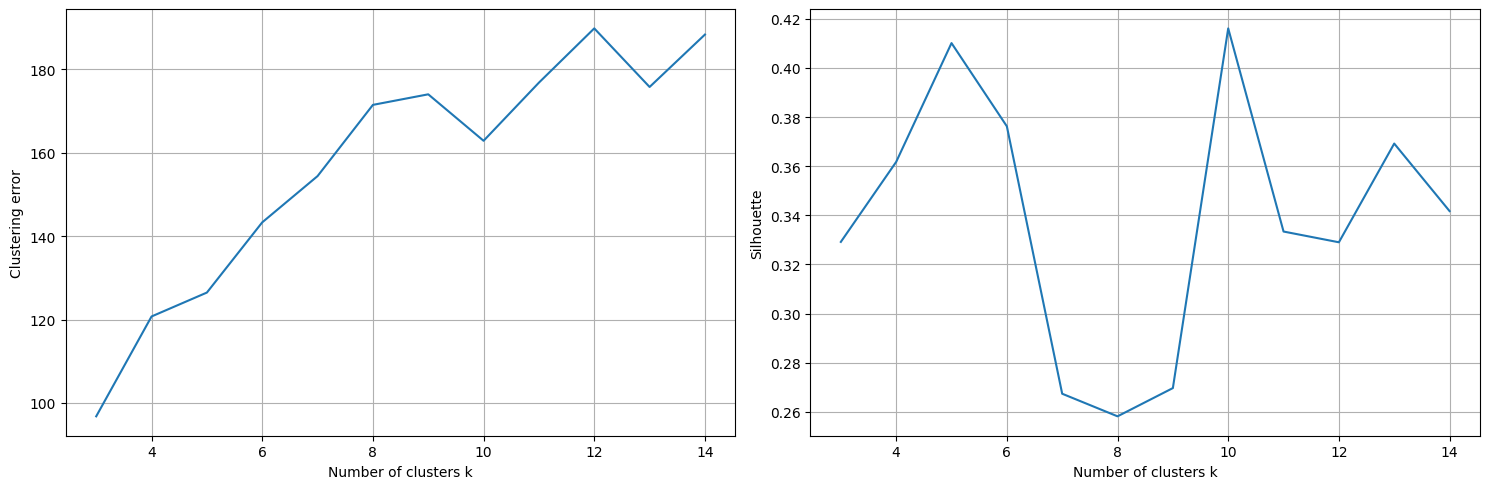

In [ ]:
n_cluster_list = []
shs_list = []
log_l_list = []
from tqdm.notebook import tqdm
for n_clusters in tqdm(range(3, 15)):
    gmm = GaussianMixture(n_components=n_clusters)
    cl_labels = gmm.fit_predict(Xs)
    silhouette  = silhouette_score(Xs, cl_labels)
    n_cluster_list.append(n_clusters)
    shs_list.append(silhouette)
    log_l_list.append(gmm.score(Xs))
fig, axs = plt.subplots(1,2, figsize=(15, 5))

axs[0].plot(
    n_cluster_list,
    log_l_list
)
axs[0].set_xlabel("Number of clusters k")
axs[0].set_ylabel("Clustering error")
axs[0].grid()

axs[1].plot(
    n_cluster_list,
    shs_list
)
axs[1].set_xlabel("Number of clusters k")
axs[1].set_ylabel("Silhouette")
axs[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
n_cluster_list = []
shs_list = []
log_l_list = []
for n_clusters in range(12, 50):
    gmm = GaussianMixture(n_components=n_clusters)
    cl_labels = gmm.fit_predict(Xs)
    silhouette  = silhouette_score(Xs, cl_labels)
    n_cluster_list.append(n_clusters)
    shs_list.append(silhouette)
    log_l_list.append(gmm.score(Xs))

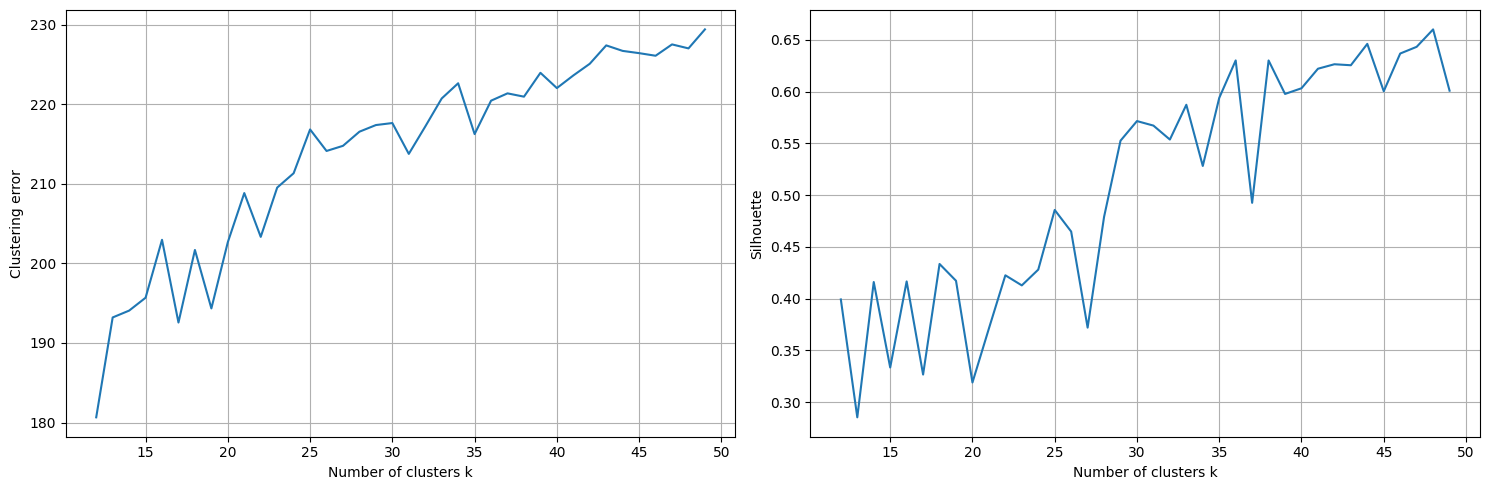

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

axs[0].plot(
    n_cluster_list,
    log_l_list
)
axs[0].set_xlabel("Number of clusters k")
axs[0].set_ylabel("Clustering error")
axs[0].grid()

axs[1].plot(
    n_cluster_list,
    shs_list
)
axs[1].set_xlabel("Number of clusters k")
axs[1].set_ylabel("Silhouette")
axs[1].grid()

plt.tight_layout()
plt.show()

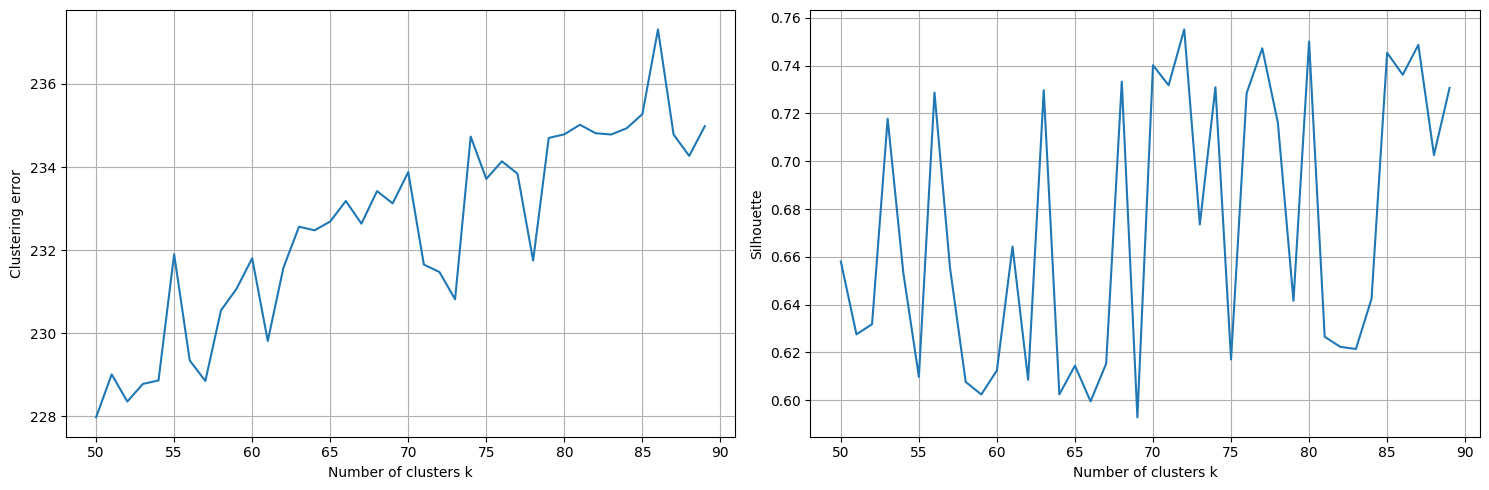

In [ ]:
n_cluster_list = []
shs_list = []
log_l_list = []
for n_clusters in range(50, 90):
    gmm = GaussianMixture(n_components=n_clusters)
    cl_labels = gmm.fit_predict(Xs)
    silhouette  = silhouette_score(Xs, cl_labels)
    n_cluster_list.append(n_clusters)
    shs_list.append(silhouette)
    log_l_list.append(gmm.score(Xs))
fig, axs = plt.subplots(1,2, figsize=(15, 5))

axs[0].plot(
    n_cluster_list,
    log_l_list
)
axs[0].set_xlabel("Number of clusters k")
axs[0].set_ylabel("Clustering error")
axs[0].grid()

axs[1].plot(
    n_cluster_list,
    shs_list
)
axs[1].set_xlabel("Number of clusters k")
axs[1].set_ylabel("Silhouette")
axs[1].grid()

plt.tight_layout()
plt.show()

  0%|          | 0/60 [00:00<?, ?it/s]

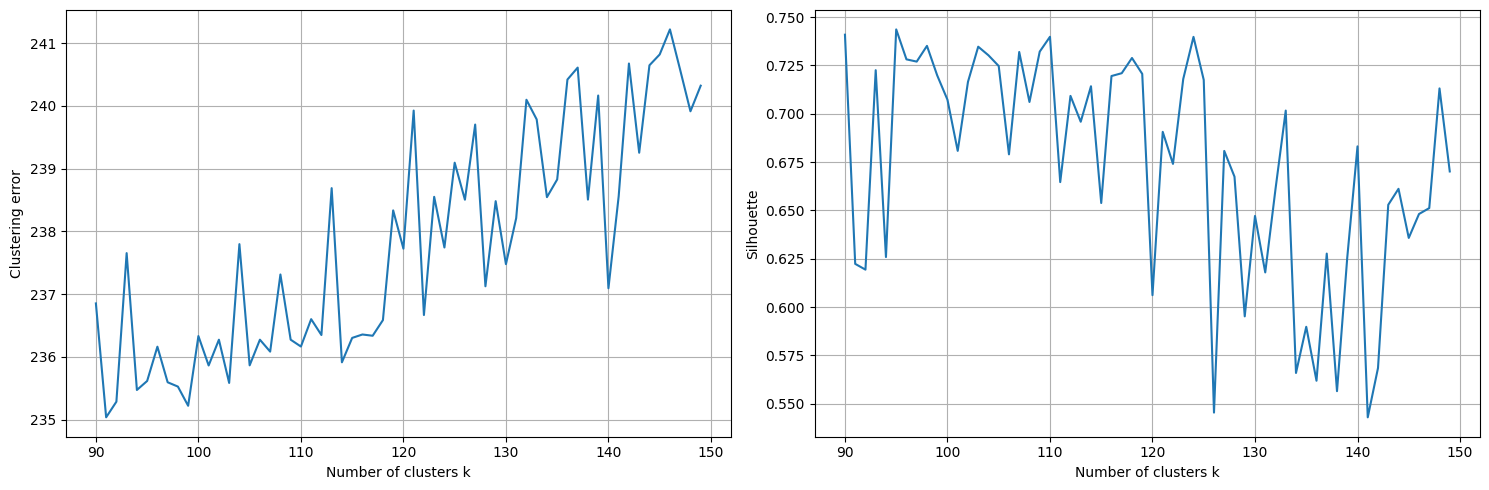

In [ ]:
n_cluster_list = []
shs_list = []
log_l_list = []
from tqdm.notebook import tqdm
for n_clusters in tqdm(range(90, 150)):
    gmm = GaussianMixture(n_components=n_clusters)
    cl_labels = gmm.fit_predict(Xs)
    silhouette  = silhouette_score(Xs, cl_labels)
    n_cluster_list.append(n_clusters)
    shs_list.append(silhouette)
    log_l_list.append(gmm.score(Xs))
fig, axs = plt.subplots(1,2, figsize=(15, 5))

axs[0].plot(
    n_cluster_list,
    log_l_list
)
axs[0].set_xlabel("Number of clusters k")
axs[0].set_ylabel("Clustering error")
axs[0].grid()

axs[1].plot(
    n_cluster_list,
    shs_list
)
axs[1].set_xlabel("Number of clusters k")
axs[1].set_ylabel("Silhouette")
axs[1].grid()

plt.tight_layout()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

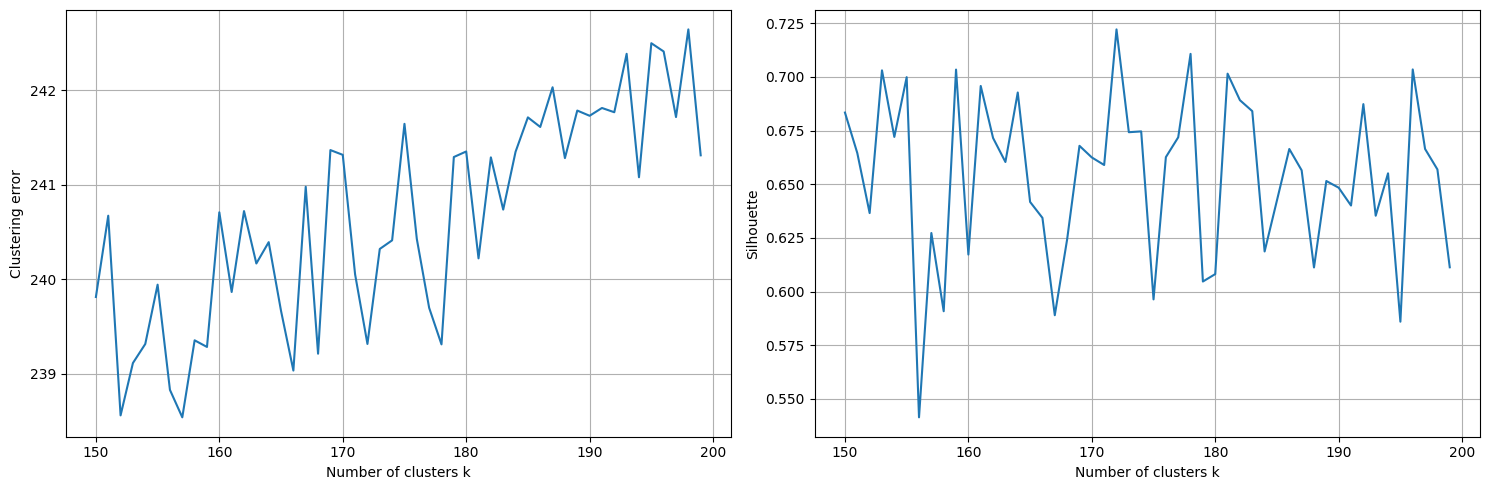

In [ ]:
n_cluster_list = []
shs_list = []
log_l_list = []
from tqdm.notebook import tqdm
for n_clusters in tqdm(range(150, 200)):
    gmm = GaussianMixture(n_components=n_clusters)
    cl_labels = gmm.fit_predict(Xs)
    silhouette  = silhouette_score(Xs, cl_labels)
    n_cluster_list.append(n_clusters)
    shs_list.append(silhouette)
    log_l_list.append(gmm.score(Xs))
fig, axs = plt.subplots(1,2, figsize=(15, 5))

axs[0].plot(
    n_cluster_list,
    log_l_list
)
axs[0].set_xlabel("Number of clusters k")
axs[0].set_ylabel("Clustering error")
axs[0].grid()

axs[1].plot(
    n_cluster_list,
    shs_list
)
axs[1].set_xlabel("Number of clusters k")
axs[1].set_ylabel("Silhouette")
axs[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# For the number of clusters i chose a number not too big and too small, looking at the graph of the ARI and the silhouette i noticed that in order to have the best
# ARI i should have choosen 22 clusters, but the silhouette was really low, at the opposite in order to choose the best silhouette i should have increased the number of clusters
# up to 72, that is a big number for our problem. So at the end i picked up 38 clusters that have a really good ARI and a good silhouette.

## Hyperparameter tuning and evaluate the clusters through clustering metrics and performance indicators

In [ ]:
#hyper parameter tuning:
#max_iter: 100-200-300
#n_init: 1-2-3
#init_params: 'kmeans','random'
#based on best log-likelihood

In [ ]:
n_clusters = 38
list_y = []
list_x = []
columns = ['max_iter','n_init','init_params','sil_val','log_li','RI','ARI']
hp = pd.DataFrame(columns = columns)
from tqdm.notebook import tqdm
# iterate over all possible combinations
for max_iter in tqdm([100,200,300]):
  for n_init in tqdm([1,2,3]):
    for init_params in ['kmeans','random']:
          gmm = GaussianMixture(n_components=n_clusters,max_iter=max_iter,n_init=n_init,init_params = init_params,covariance_type = 'full')
          prediction = gmm.fit_predict(Xs)
          new_row={'max_iter': max_iter,'n_init': n_init,'init_params': init_params,'sil_val':silhouette_score(Xs, prediction),'log_li':gmm.score(Xs),'RI':rand_score(np.ravel(y), prediction),'ARI':adjusted_rand_score(np.ravel(y), prediction)}
          hp = hp.append(new_row,ignore_index=True)

hp['ARI'] = pd.to_numeric(hp['ARI'], errors='coerce')
max_val = hp.iloc[hp['ARI'].idxmax()]
print(max_val)

## Report a coarse analysis of the detected clusters

In [ ]:
gmm = GaussianMixture(n_components=38,max_iter=300,n_init=1,init_params = 'kmeans',covariance_type = 'full')
cl_labels = gmm.fit_predict(Xs)


In [ ]:
(unique,counts) = np.unique(cl_labels,return_counts=True)
print(counts)

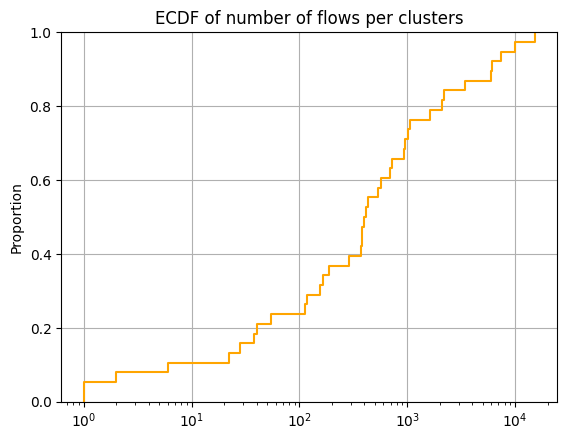

In [ ]:
# Visualize the ECDF of clusters

plt.figure()
sns.ecdfplot(counts,color = 'orange',log_scale = True) # x-axis is in logarithm scale
plt.title('ECDF of number of flows per clusters')
plt.grid()
plt.show()

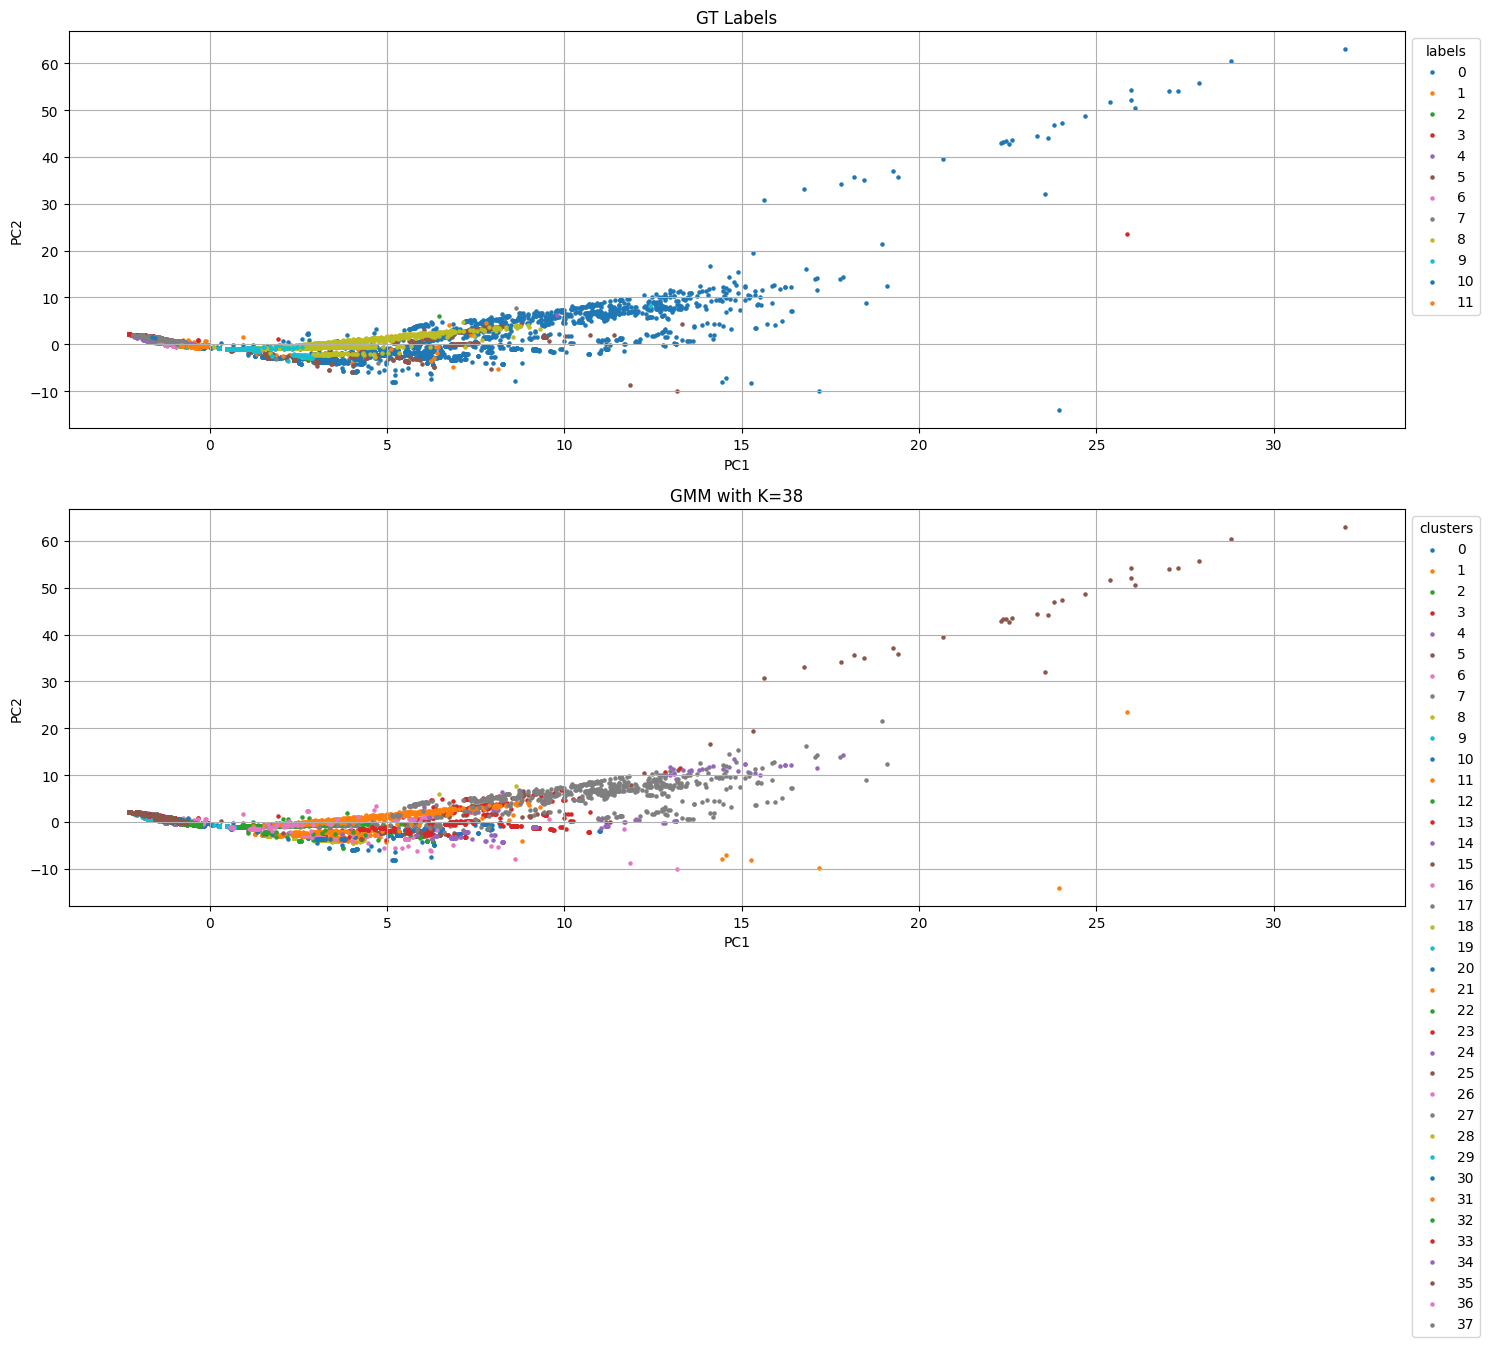

In [ ]:
#2D PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
projection = pca.fit_transform(Xs)
projection = pd.DataFrame(projection)
#gmm = GaussianMixture(n_components=38,max_iter=300,n_init=1,init_params = 'kmeans',covariance_type = 'full')
#cl_labels = gmm.fit_predict(Xs)

projection['cidBest'] = [x for x in cl_labels]
projection['label'] = y.reshape(-1)

fig, axs = plt.subplots(2, 1, figsize=(15, 13))

for i in np.unique(y):
    subdf = projection[projection.label==i]
    axs[0].scatter(subdf[0], subdf[1], label=i, s=5)
axs[0].grid()
lgnd = axs[0].legend(title='labels',bbox_to_anchor=(1, 1), loc="upper left")
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].set_title('GT Labels')


for i in range(len(set(cl_labels))):
    subdf = projection[projection.cidBest==i]
    axs[1].scatter(subdf[0], subdf[1], label=i, s=5)
axs[1].grid()
lgnd = axs[1].legend(title = 'clusters',bbox_to_anchor=(1, 1), loc="upper left")

axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].set_title(f'GMM with K={38}')

plt.tight_layout()
plt.show()

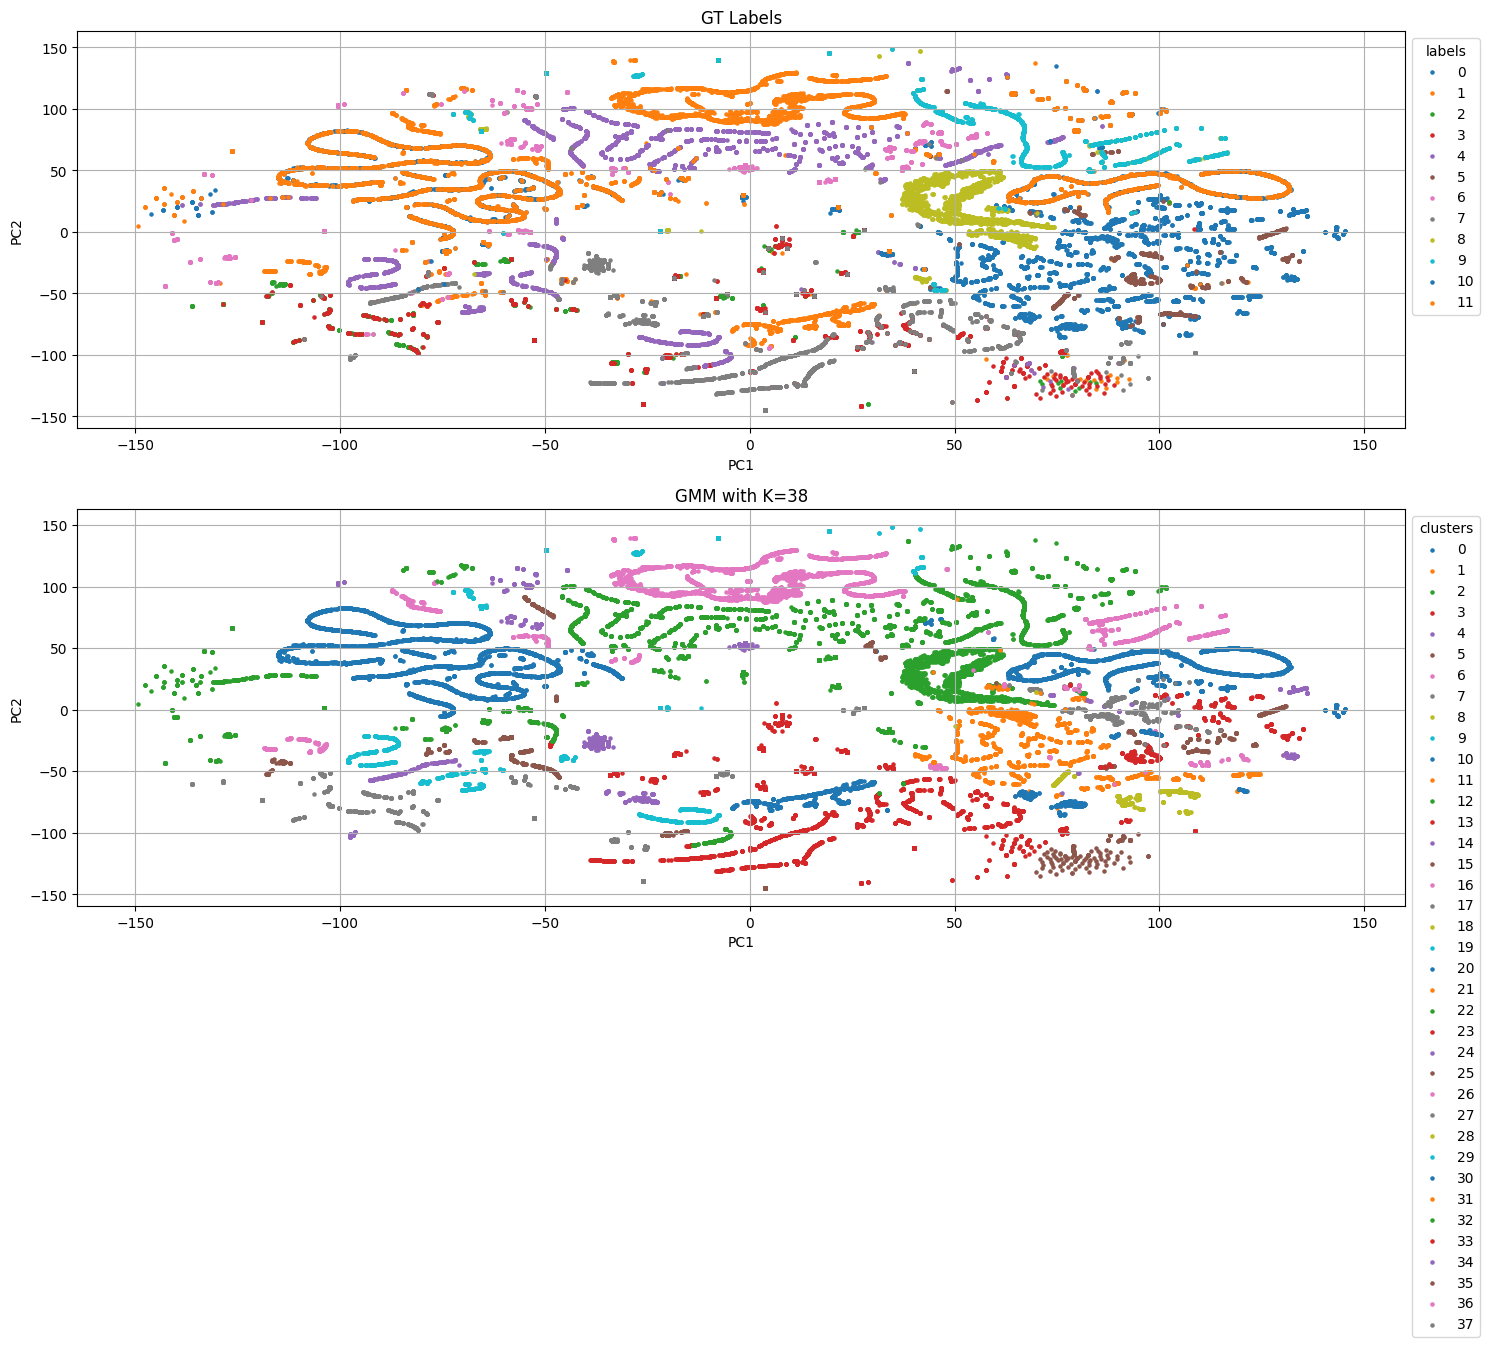

In [ ]:
#2D tSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
projection = tsne.fit_transform(Xs)
projection = pd.DataFrame(projection)
#gmm = GaussianMixture(n_components=38,max_iter=300,n_init=1,init_params = 'kmeans',covariance_type = 'full')
#cl_labels = gmm.fit_predict(Xs)

projection['cidBest'] = [x for x in cl_labels]
projection['label'] = y.reshape(-1)

fig, axs = plt.subplots(2, 1, figsize=(15, 13))

for i in np.unique(y):
    subdf = projection[projection.label==i]
    axs[0].scatter(subdf[0], subdf[1], label=i, s=5)
axs[0].grid()
lgnd = axs[0].legend(title='labels',bbox_to_anchor=(1, 1), loc="upper left")
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].set_title('GT Labels')


for i in range(len(set(cl_labels))):
    subdf = projection[projection.cidBest==i]
    axs[1].scatter(subdf[0], subdf[1], label=i, s=5)
axs[1].grid()
lgnd = axs[1].legend(title = 'clusters',bbox_to_anchor=(1, 1), loc="upper left")

axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].set_title(f'GMM with K={38}')

plt.tight_layout()
plt.show()

# **Section 4**

In [ ]:
labels = pd.DataFrame({'labels':y})
clusters = pd.DataFrame({'clusters':cl_labels})
clu_gt_labels = pd.merge(labels,clusters,left_index=True, right_index=True)
clu_gt_labels

## Tables (cluster-labels and label-clusters)

In [ ]:
#we want to see for each label the corresponding clusters
from prettytable import PrettyTable
gb = clu_gt_labels.groupby('labels')
tabella = PrettyTable()
tabella.field_names = ["Label", "Clusters"]
for g,k in gb:
  tabella.add_row([g, set(k.clusters)])
print(tabella)

+-------+---------------------------------------------------------------------------------------------+
| Label |                                           Clusters                                          |
+-------+---------------------------------------------------------------------------------------------+
|   0   | {0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 13, 17, 19, 21, 24, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37} |
|   1   |       {1, 4, 5, 7, 8, 11, 12, 16, 18, 19, 20, 21, 22, 24, 26, 29, 31, 32, 34, 35, 37}       |
|   2   |                             {32, 1, 3, 5, 8, 12, 15, 22, 25, 26}                            |
|   3   |                       {0, 1, 32, 3, 4, 10, 12, 15, 20, 22, 23, 26, 27}                      |
|   4   |                                  {32, 1, 0, 14, 18, 21, 22}                                 |
|   5   |                  {1, 34, 35, 4, 37, 6, 7, 5, 8, 2, 11, 19, 21, 24, 29, 31}                  |
|   6   |                                {0, 1, 3, 10, 12, 15, 2

In [ ]:
#we want to see for each clsuter the corresponding labels
from prettytable import PrettyTable
gb = clu_gt_labels.groupby('clusters')
tabella = PrettyTable()
tabella.field_names = ["Cluster", "Labels"]
for g,k in gb:
  tabella.add_row([g, set(k.labels)])
print(tabella)

+---------+-------------------------------------+
| Cluster |                Labels               |
+---------+-------------------------------------+
|    0    |       {0, 3, 4, 6, 7, 10, 11}       |
|    1    | {0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11} |
|    2    |                {0, 5}               |
|    3    |             {2, 3, 6, 7}            |
|    4    |           {0, 1, 3, 5, 9}           |
|    5    |           {0, 1, 2, 5, 7}           |
|    6    |                {0, 5}               |
|    7    |              {0, 1, 5}              |
|    8    |             {0, 1, 2, 5}            |
|    9    |                 {0}                 |
|    10   |            {10, 3, 6, 7}            |
|    11   |           {0, 1, 5, 8, 9}           |
|    12   |           {1, 2, 3, 6, 7}           |
|    13   |                 {0}                 |
|    14   |                {8, 4}               |
|    15   |             {2, 3, 6, 7}            |
|    16   |                 {1}                 |


In [ ]:
#we group per clusters and we see the number of labels belonging to clusters, starting from which clusters have only 1 element and so on
gb = clu_gt_labels.groupby('clusters')
cl = 0;
for i in range(1,38):
  if(cl!=38):
    print(f'Cluster which elements belong to {i} class:')
  for g,k in gb:
    if (k.labels.unique().size==i):
      cl+=1
      print(f'Cluster: {g}')
      print(f'Labels: {k.labels.unique()}')


Cluster which elements belong to 1 class:
Cluster: 9
Labels: [0]
Cluster: 13
Labels: [0]
Cluster: 16
Labels: [1]
Cluster: 23
Labels: [3]
Cluster: 28
Labels: [0]
Cluster: 30
Labels: [0]
Cluster: 36
Labels: [0]
Cluster which elements belong to 2 class:
Cluster: 2
Labels: [0 5]
Cluster: 6
Labels: [0 5]
Cluster: 14
Labels: [4 8]
Cluster: 18
Labels: [1 4]
Cluster: 25
Labels: [2 7]
Cluster: 27
Labels: [0 3]
Cluster: 31
Labels: [1 5]
Cluster which elements belong to 3 class:
Cluster: 7
Labels: [1 0 5]
Cluster: 17
Labels: [0 8 9]
Cluster: 19
Labels: [0 1 5]
Cluster: 33
Labels: [0 8 9]
Cluster: 35
Labels: [0 1 5]
Cluster: 37
Labels: [1 0 5]
Cluster which elements belong to 4 class:
Cluster: 3
Labels: [2 3 6 7]
Cluster: 8
Labels: [1 0 2 5]
Cluster: 10
Labels: [ 3  6  7 10]
Cluster: 15
Labels: [2 3 6 7]
Cluster: 20
Labels: [1 3 6 7]
Cluster: 24
Labels: [1 0 5 7]
Cluster which elements belong to 5 class:
Cluster: 4
Labels: [1 0 3 5 9]
Cluster: 5
Labels: [0 1 2 5 7]
Cluster: 11
Labels: [1 5 0 8 9]


## Histograms

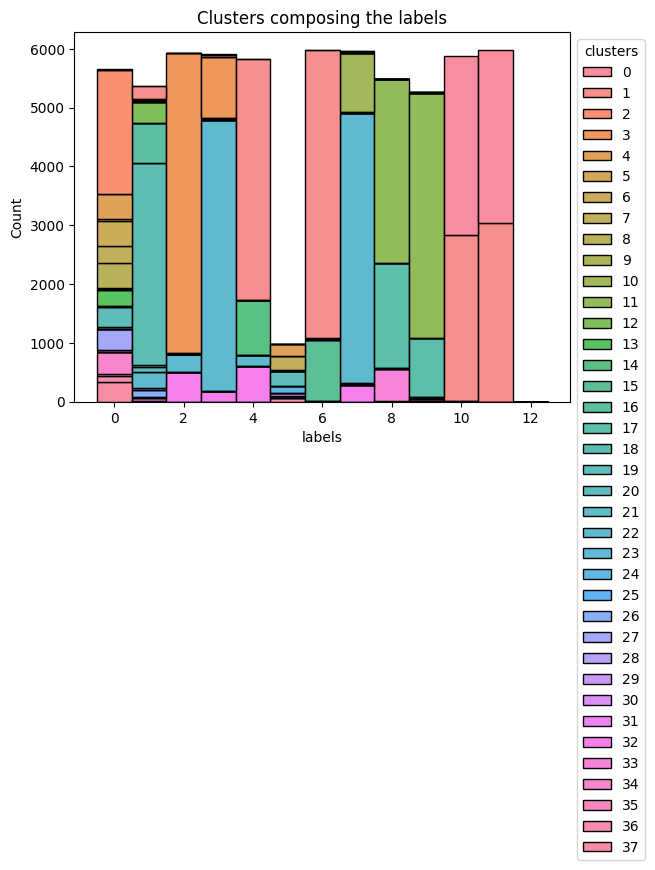

In [ ]:
#we plot for each label the clusters representing it
ax = sns.histplot(
    data = clu_gt_labels,
    x = "labels", # the column you want to check
    hue = "clusters", # check the distribution of different flow types
    palette="husl",
    multiple="stack",
    discrete = True,
    bins = 12,
    alpha=0.8,
    binrange = (0,12)
)
plt.title('Clusters composing the labels')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

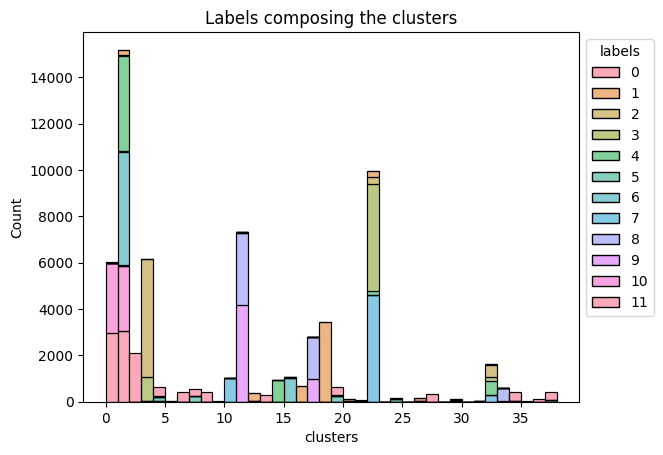

In [ ]:
#
ax = sns.histplot(
    data = clu_gt_labels,
    x = "clusters", # the column you want to check
    hue = "labels", # check the distribution of different flow types
    palette="husl",
    alpha = 0.6,
    multiple="stack",
    bins = 38,
    binrange = (0,38)
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Labels composing the clusters')
plt.show()

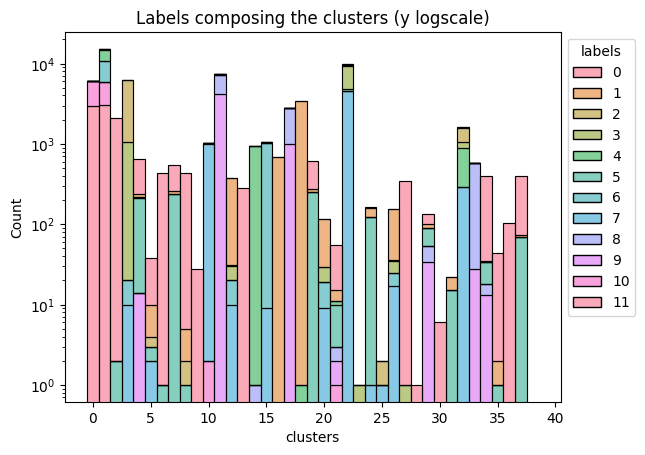

In [ ]:
ax = sns.histplot(
    data = clu_gt_labels,
    x = "clusters", # the column you want to check
    hue = "labels", # check the distribution of different flow types
    palette="husl",
    alpha = 0.6,
    multiple="stack",
    discrete=True,
    bins = 38,
    binrange = (0,38)
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Labels composing the clusters (y logscale)')
plt.yscale("log")
plt.show()

## ECDF

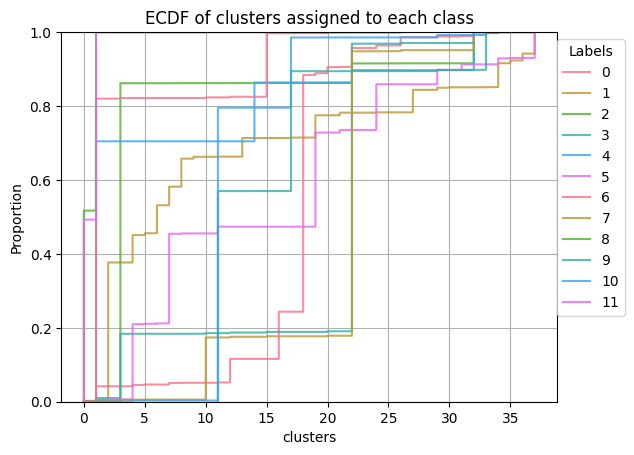

In [ ]:
# Visualize the ECDF of clusters
sns.set_palette('husl')
plt.figure()
for lab in clu_gt_labels['labels'].unique():
  df_label = clu_gt_labels[clu_gt_labels.labels==lab]
  sns.ecdfplot(df_label.clusters,alpha=0.8)
plt.legend(np.sort(clu_gt_labels['labels'].unique()))
plt.title('ECDF of clusters assigned to each class')
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right',title ='Labels',labels = np.sort(clu_gt_labels['labels'].unique()))
plt.grid()
plt.show()

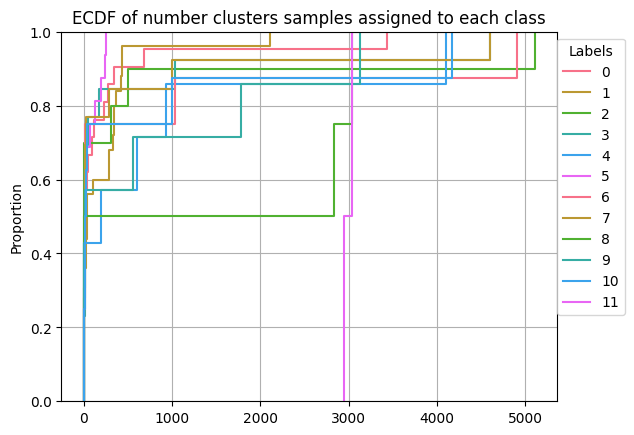

In [ ]:
# Visualize the ECDF of clusters

plt.figure()
for lab in clu_gt_labels['labels'].unique():
  df_label = clu_gt_labels[clu_gt_labels.labels==lab]
  (unique,counts) = np.unique(df_label.clusters,return_counts=True)
  sns.ecdfplot(counts)
plt.legend(np.sort(clu_gt_labels['labels'].unique()))
plt.title('ECDF of number clusters samples assigned to each class')
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right',title ='Labels',labels = np.sort(clu_gt_labels['labels'].unique()))
plt.grid()
plt.show()

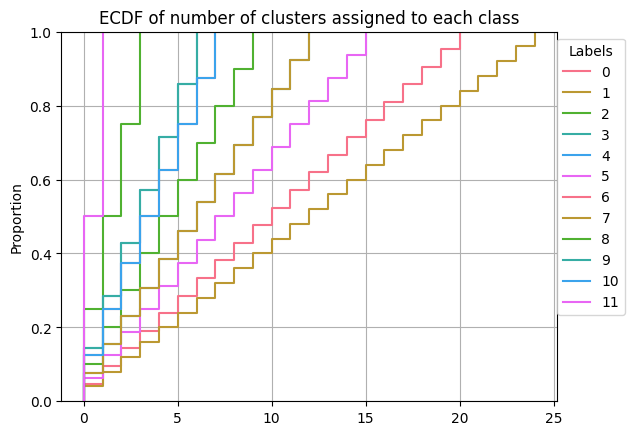

In [ ]:
# Visualize the ECDF of clusters

plt.figure()
for lab in clu_gt_labels['labels'].unique():
  df_label = clu_gt_labels[clu_gt_labels.labels==lab]
  (unique,counts) = np.unique(df_label.clusters,return_counts=True)
  sns.ecdfplot(np.argsort(counts))
plt.legend(np.sort(clu_gt_labels['labels'].unique()))
plt.title('ECDF of number of clusters assigned to each class')
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right',title ='Labels',labels = np.sort(clu_gt_labels['labels'].unique()))
plt.grid()
plt.show()

## Importance of features


In [ ]:
top_features = []
for i in range(len(clu_gt_labels['clusters'].unique())):
  indici_maggiori = np.argsort(np.diag(gmm.covariances_[i]))[-5:]
  [top_features.append(l) for l in indici_maggiori]
  print(f"Cluster {i} features più importanti: {Xs.columns[indici_maggiori]}")
np.sort(top_features)

Cluster 0 features più importanti: Index(['Total Length of Fwd Packets', ' Max Packet Length', ' Source Port_-1',
       ' Min Packet Length', 'Fwd Packets/s'],
      dtype='object')
Cluster 1 features più importanti: Index([' Destination Port_443', ' Down/Up Ratio', 'Fwd Packets/s',
       ' Flow IAT Max', 'Init_Win_bytes_forward'],
      dtype='object')
Cluster 2 features più importanti: Index([' Destination Port_53', ' Destination Port_80', ' Packet Length Std',
       ' Down/Up Ratio', ' Bwd Packet Length Min'],
      dtype='object')
Cluster 3 features più importanti: Index([' Min Packet Length', ' Fwd Packet Length Std', ' Flow IAT Max',
       ' Source Port_-1', 'Total Length of Fwd Packets'],
      dtype='object')
Cluster 4 features più importanti: Index([' Total Fwd Packets', 'Total Length of Fwd Packets',
       ' Max Packet Length', ' Min Packet Length', 'Fwd Packets/s'],
      dtype='object')
Cluster 5 features più importanti: Index([' Bwd IAT Min', ' Flow IAT Min', ' Flow I

array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  8,  8,
        8,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17,
       17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20,
       21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24,
       24, 24, 24, 24, 24, 25, 25, 25, 25, 26, 27, 27, 27, 27, 28, 29, 29,
       29, 29, 35, 37, 37, 37, 37, 39, 40, 40, 41, 41, 41, 42, 42, 42, 42,
       42, 42, 42])

In [ ]:
from prettytable import PrettyTable

tabella = PrettyTable()
tabella.field_names = ["Cluster", "Features"]

top_features = []
for i in range(len(clu_gt_labels['clusters'].unique())):
  indici_maggiori = np.argsort(np.diag(gmm.covariances_[i]))[-5:]
  [top_features.append(l) for l in indici_maggiori]
  tabella.add_row([f'Cluster {i}', set(Xs.columns[indici_maggiori])])
print(tabella)

+------------+-----------------------------------------------------------------------------------------------------------------------------+
|  Cluster   |                                                           Features                                                          |
+------------+-----------------------------------------------------------------------------------------------------------------------------+
| Cluster 0  | {' Max Packet Length', 'Total Length of Fwd Packets', ' Min Packet Length', ' Packet Length Std', ' Fwd Packet Length Std'} |
| Cluster 1  |       {' Max Packet Length', 'Total Length of Fwd Packets', ' Min Packet Length', ' Source Port_-1', 'Fwd Packets/s'}       |
| Cluster 2  |      {' Down/Up Ratio', ' Destination Port_80', ' Packet Length Std', ' Bwd Packet Length Min', ' Destination Port_53'}     |
| Cluster 3  |      {' Max Packet Length', 'Total Length of Fwd Packets', ' Min Packet Length', ' Total Fwd Packets', 'Fwd Packets/s'}     |
| Cluster 4  

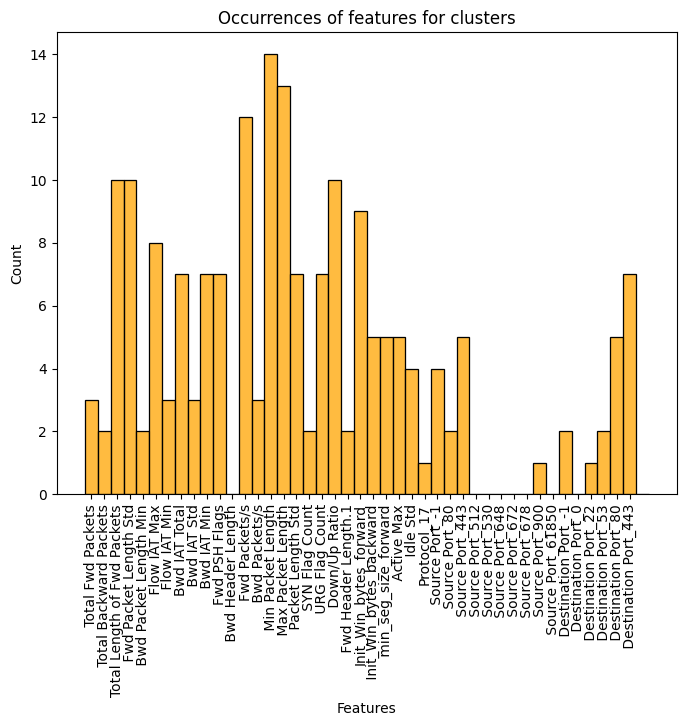

In [ ]:
plt.figure(figsize = (8,6))
ax = sns.histplot(
    data = np.sort(top_features),
    color = 'orange',
    multiple="stack",
    discrete=True,
    bins = 43,
    binrange = (0,43)
)
plt.xticks(rotation=90)
plt.title('Occurrences of features for clusters')
ax.set_xticks([i for i in range(Xs.columns.size)])
ax.set_xticklabels([i for i in Xs.columns.values])
plt.xlabel('Features')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

df_copy = Xs.copy()
df_copy['cluster'] = cl_labels
df_copy['label'] = y

for label in sorted(clu_gt_labels['labels'].unique()):
  #uncomment to visualize cluster assigning

  #clusterings = clu_gt_labels[clu_gt_labels['labels']==label]['clusters']
  #print(label, "   ", clusterings.unique())
  #print(clusterings.value_counts())

  #select a label
  df1 = df_copy[df_copy["label"] == label]
  df1 = df1.drop("label", axis = 1) #remove GT
  yy = df1["cluster"]                #train on clusters to get feature importance
  df1 = df1.drop("cluster", axis = 1)
  clf = DecisionTreeClassifier(random_state=42)
  clf.fit(df1, yy)

  feature_importance = clf.feature_importances_
  print(f"\nFeature Importance for label {label}:")
  for feature, importance in sorted(zip(df1.columns, feature_importance), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{feature}: {importance:.4f}")



Feature Importance for label 0:
 Destination Port_53: 0.3041
 Init_Win_bytes_backward: 0.0848
 Source Port_-1: 0.0834
 Destination Port_443: 0.0752
Fwd PSH Flags: 0.0668

Feature Importance for label 1:
Total Length of Fwd Packets: 0.3392
 Fwd Header Length.1: 0.3335
 Source Port_530: 0.0972
 Min Packet Length: 0.0615
 Source Port_512: 0.0423

Feature Importance for label 2:
 Fwd Header Length.1: 0.5876
 Source Port_900: 0.4017
 Min Packet Length: 0.0048
 Source Port_-1: 0.0020
 Max Packet Length: 0.0011

Feature Importance for label 3:
 Source Port_-1: 0.7456
 Fwd Header Length.1: 0.1225
 Max Packet Length: 0.0360
 Source Port_900: 0.0308
 min_seg_size_forward: 0.0307

Feature Importance for label 4:
 Source Port_61850: 0.4919
 min_seg_size_forward: 0.3699
Total Length of Fwd Packets: 0.1331
Fwd Packets/s: 0.0036
 Max Packet Length: 0.0008

Feature Importance for label 5:
 Source Port_-1: 0.2721
Init_Win_bytes_forward: 0.2224
 Destination Port_22: 0.1630
 Init_Win_bytes_backward: 0.1

Index([' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Fwd Packet Length Std',
       ' Bwd Packet Length Min', ' Flow IAT Max', ' Flow IAT Min',
       'Bwd IAT Total', ' Bwd IAT Std', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Std',
       ' SYN Flag Count', ' URG Flag Count', ' Down/Up Ratio',
       ' Fwd Header Length.1', 'Init_Win_bytes_forward',
       ' Init_Win_bytes_backward', ' min_seg_size_forward', ' Active Max',
       ' Idle Std', 'Protocol_17', ' Source Port_-1', ' Source Port_80',
       ' Source Port_443', ' Source Port_512', ' Source Port_530',
       ' Source Port_648', ' Source Port_672', ' Source Port_678',
       ' Source Port_900', ' Source Port_61850', ' Destination Port_-1',
       ' Destination Port_0', ' Destination Port_22', ' Destination Port_53',
       ' Destination Port_80', ' Destination Port_

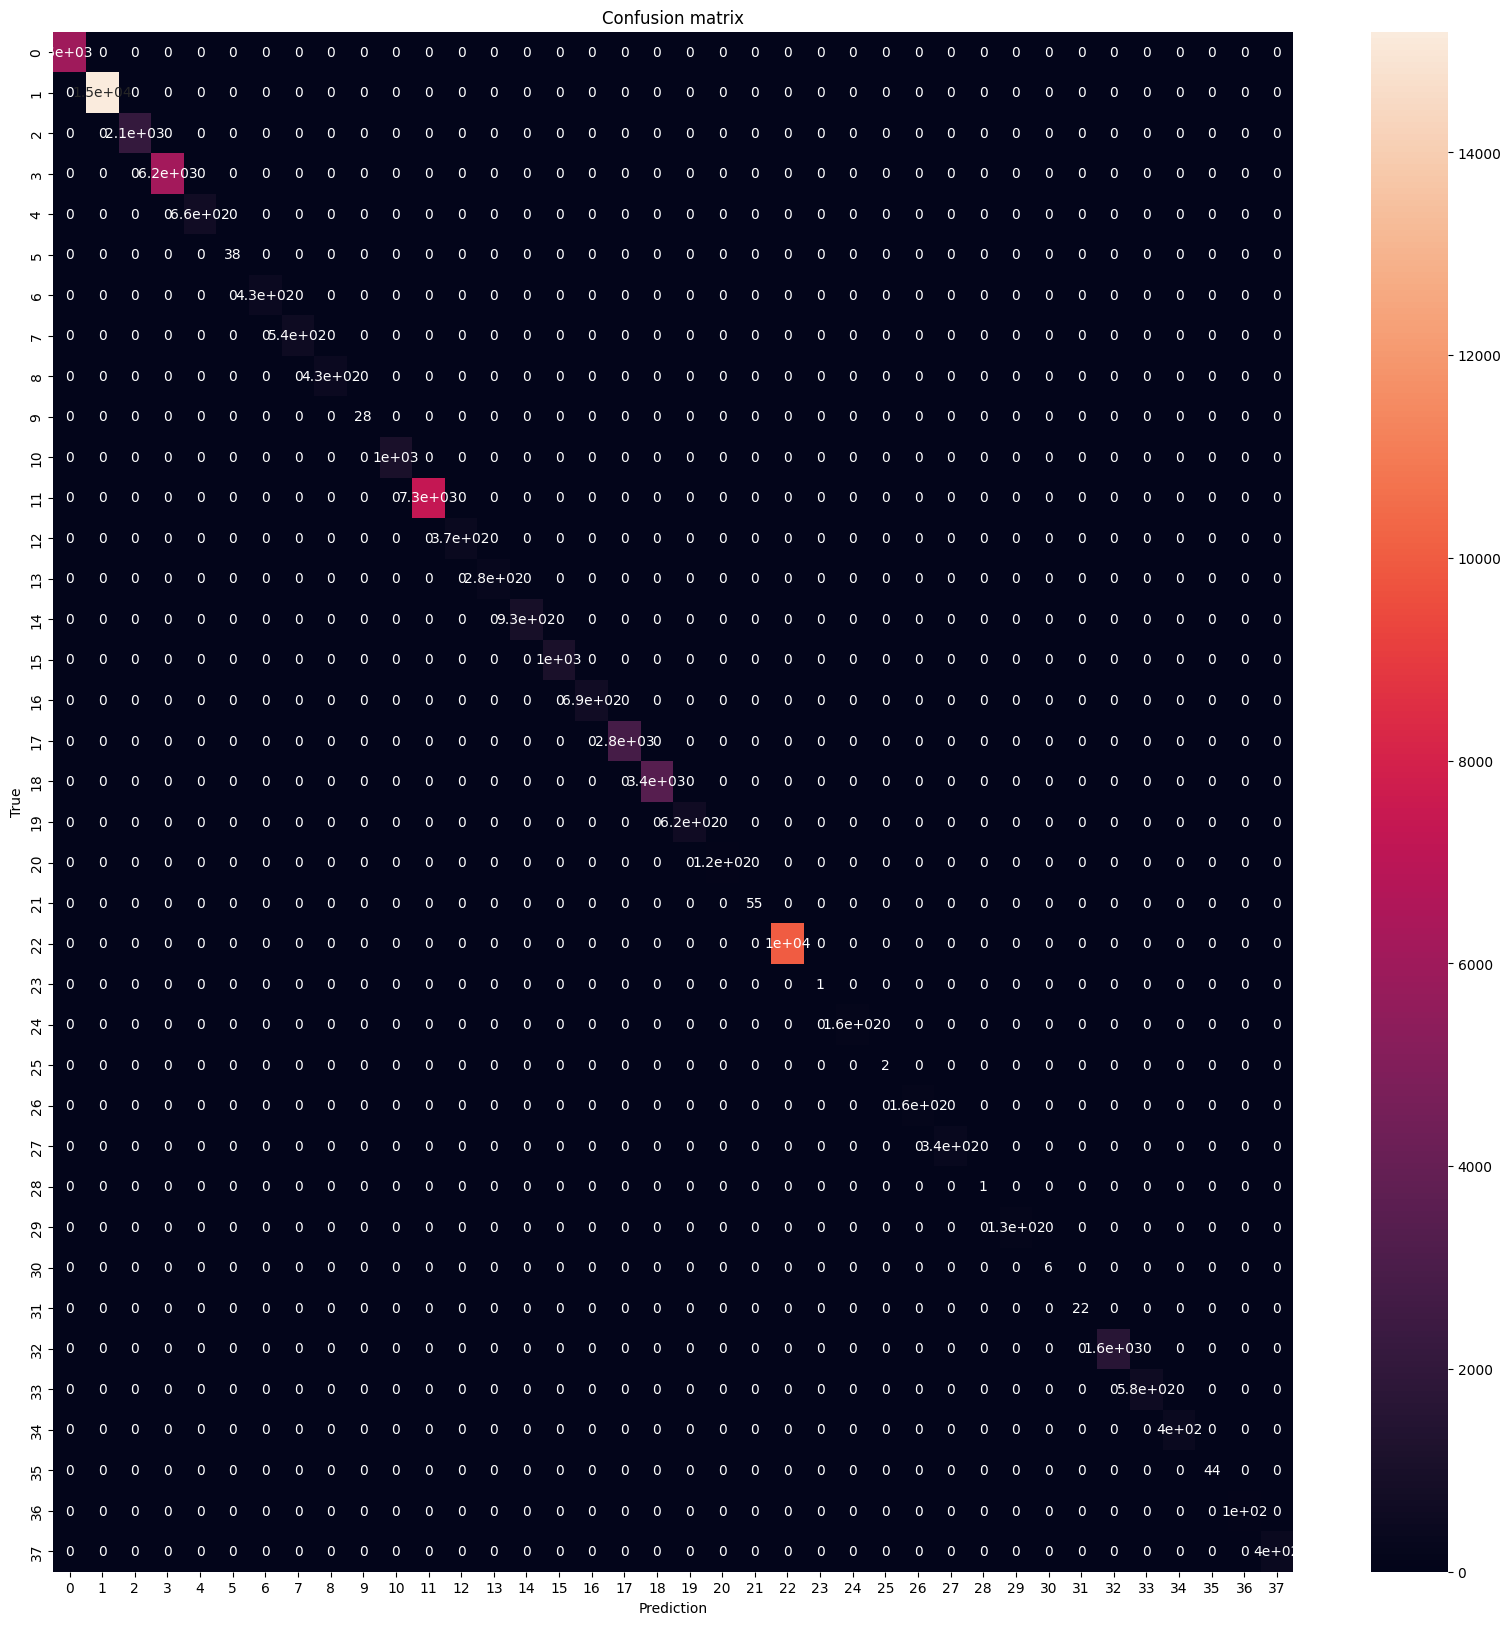

In [ ]:
from sklearn.metrics import confusion_matrix

dff = Xs.copy()
y = cl_labels
print(dff.columns)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(dff, y)
y_pred = clf.predict(dff)
conf = confusion_matrix(y, y_pred)

plt.figure(figsize=(20,20))
sns.heatmap(conf, annot=True)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from IPython.display import Image

arr = [ str(i) for i in range(38)]

dot_data = export_graphviz(clf, out_file = None, feature_names = Xs.columns, class_names = arr, filled = True, rounded = True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('decisiontree.png')
Image(filename = 'decisiontree.png')
#display(graphviz.Source(dot_data))

Output hidden; open in https://colab.research.google.com to view.

## Similar clusters and their features

In [ ]:

from itertools import groupby
from prettytable import PrettyTable
top_features = []
for i in range(len(clu_gt_labels['clusters'].unique())):
  indici_maggiori = np.argsort(np.diag(gmm.covariances_[i]))[-2:]
  list = []

  list.append(indici_maggiori[0])
  list.append(indici_maggiori[1])
  list.append(i)
  top_features.append(list)

tabella = PrettyTable()
tabella.field_names = ["Features", "Clusters"]

df = pd.DataFrame(data = top_features,columns = ['Feature1','Feature2','Cluster'] )
df['Count'] = 1
df_grouped = df.groupby(['Feature1','Feature2'])#['Count'].sort_values(ascending = False).head()
for g,k in df_grouped:
  if(len(k.Cluster.unique())>1):
    tabella.add_row([g, set(k.Cluster)])
print(tabella)

+----------+----------------+
| Features |    Clusters    |
+----------+----------------+
| (10, 42) |    {28, 23}    |
| (12, 23) |  {10, 26, 14}  |
| (14, 12) | {1, 3, 22, 15} |
| (14, 23) |    {12, 20}    |
| (21, 19) |    {27, 37}    |
| (29, 13) |    {34, 5}     |
+----------+----------------+


In [ ]:
from prettytable import PrettyTable
top_features = []
for i in range(len(clu_gt_labels['clusters'].unique())):
  indici_maggiori = np.argsort(np.diag(gmm.covariances_[i]))[-3:]
  lista = []

  lista.append(indici_maggiori[0])
  lista.append(indici_maggiori[1])
  lista.append(indici_maggiori[2])
  lista.append(i)
  top_features.append(lista)

tabella = PrettyTable()
tabella.field_names = ["Features", "Clusters"]

df = pd.DataFrame(data = top_features,columns = ['Feature1','Feature2','Feature3','Cluster'] )
df['Count'] = 1
df_grouped = df.groupby(['Feature1','Feature2','Feature3'])#['Count'].sort_values(ascending = False).head()
for g,k in df_grouped:
  if(len(k.Cluster.unique())>1):
    tabella.add_row([g, set(k.Cluster.unique())])
print(tabella)

+--------------+--------------+
|   Features   |   Clusters   |
+--------------+--------------+
| (12, 14, 23) |   {12, 20}   |
| (14, 12, 23) | {10, 26, 14} |
| (15, 14, 12) | {3, 22, 15}  |
| (18, 10, 42) |   {28, 23}   |
+--------------+--------------+


In [ ]:
from prettytable import PrettyTable
top_features = []
for i in range(len(clu_gt_labels['clusters'].unique())):
  indici_maggiori = np.argsort(np.diag(gmm.covariances_[i]))[-4:]
  lista = []

  lista.append(indici_maggiori[0])
  lista.append(indici_maggiori[1])
  lista.append(indici_maggiori[2])
  lista.append(indici_maggiori[3])
  lista.append(i)
  top_features.append(lista)

tabella = PrettyTable()
tabella.field_names = ["Features", "Clusters"]

df = pd.DataFrame(data = top_features,columns = ['Feature1','Feature2','Feature3','Feature4','Cluster'] )
df['Count'] = 1
df_grouped = df.groupby(['Feature1','Feature2','Feature3','Feature4'])#['Count'].sort_values(ascending = False).head()
for g,k in df_grouped:
  if(len(k.Cluster.unique())>1):
    tabella.add_row([g, set(k.Cluster.unique())])
print(tabella)

+------------------+--------------+
|     Features     |   Clusters   |
+------------------+--------------+
| (2, 15, 14, 12)  |   {3, 15}    |
| (15, 12, 14, 23) |   {12, 20}   |
| (15, 14, 12, 23) | {10, 26, 14} |
| (17, 18, 10, 42) |   {28, 23}   |
+------------------+--------------+


##Similar attack

In [ ]:
#In this section we take the top3 most rilevant features in common between the similar attacks among the top5 features ofeach cluster

In [ ]:
y = Y.copy()

In [ ]:
yy =y.values

In [ ]:
top_features = []
for i in range(len(clu_gt_labels['clusters'].unique())):
  indici_maggiori = np.argsort(np.diag(gmm.covariances_[i]))[-5:]
  top_features.append(indici_maggiori)
np.sort(top_features)

array([[ 2,  3, 14, 15, 16],
       [ 2, 12, 14, 15, 27],
       [ 4, 16, 19, 40, 41],
       [ 0,  2, 12, 14, 15],
       [ 3,  7, 21, 41, 42],
       [13, 29, 37, 39, 42],
       [ 3,  5,  7, 10, 25],
       [ 3,  9, 10, 19, 22],
       [ 5,  8, 12, 21, 42],
       [ 1,  7, 15, 16, 19],
       [12, 14, 15, 20, 23],
       [ 9, 12, 13, 19, 21],
       [ 2, 12, 14, 15, 23],
       [ 3,  6, 10, 19, 21],
       [12, 14, 15, 23, 26],
       [ 0,  2, 12, 14, 15],
       [ 2,  3, 14, 20, 27],
       [ 5,  6,  9, 24, 25],
       [ 2,  3,  5, 14, 27],
       [ 7, 16, 19, 37, 41],
       [ 2, 12, 14, 15, 23],
       [ 5,  7,  8, 24, 25],
       [ 2,  5, 12, 14, 15],
       [10, 16, 17, 18, 42],
       [ 3, 18, 19, 21, 24],
       [ 0,  1,  5,  7,  9],
       [ 2, 12, 14, 15, 23],
       [ 3, 16, 18, 19, 21],
       [10, 16, 17, 18, 42],
       [ 4,  9, 18, 40, 41],
       [ 9, 21, 22, 28, 29],
       [ 5,  6, 10, 14, 15],
       [12, 14, 15, 27, 35],
       [ 7,  8,  9, 24, 25],
       [13, 18

In [ ]:
#similarity for labels 10-11
labels = pd.DataFrame({'labels':yy})
clusters = pd.DataFrame({'clusters':cl_labels})
simil1011 = pd.merge(labels,clusters,left_index=True, right_index=True)
simil10 = simil1011[(simil1011['labels'] ==10)]
simil11 = simil1011[(simil1011['labels'] ==11)]
set10 = set(simil10['clusters'])
set11 = set(simil11['clusters'])
intersezione = set10.intersection(set11)

vettore_intersezione = list(intersezione)

simil = simil10.append(simil11)
df_filtrato = simil[simil['clusters'].isin(vettore_intersezione)]
cls = df_filtrato.groupby('clusters').count()['labels'].sort_values(ascending=False)[:3].index

if len(cls)==3:
  f1 = set(top_features[a[0]])
  f2 = set(top_features[a[1]])
  f3 = set(top_features[a[2]])
  inters1 = f1.intersection(f2)
  inters = inters1.intersection(f3)
  print(list(inters))
elif len(cls) == 2:
  f1 = set(top_features[a[0]])
  f2 = set(top_features[a[1]])
  inters = f1.intersection(f2)
  print(Xs.columns[list(inters)])
else:
  print(cls)

Int64Index([0, 1], dtype='int64', name='clusters')
Index(['Total Length of Fwd Packets', ' Min Packet Length',
       ' Max Packet Length'],
      dtype='object')


<ipython-input-190-0901144ac00b>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simil = simil10.append(simil11)


In [ ]:
#Similarity for labels 8-9
labels = pd.DataFrame({'labels':yy})
clusters = pd.DataFrame({'clusters':cl_labels})
simil89 = pd.merge(labels,clusters,left_index=True, right_index=True)
simil8 = simil89[(simil1011['labels'] ==8)]
simil9 = simil89[(simil1011['labels'] ==9)]
set8 = set(simil8['clusters'])
set9 = set(simil9['clusters'])
intersezione = set8.intersection(set9)

vettore_intersezione = list(intersezione)
simil = simil8.append(simil9)
df_filtrato = simil[simil['clusters'].isin(vettore_intersezione)]
cls = df_filtrato.groupby('clusters').count()['labels'].sort_values(ascending=False)[:3].index
if len(cls)==3:
  f1 = set(top_features[cls[0]])
  f2 = set(top_features[cls[1]])
  f3 = set(top_features[cls[2]])
  inters1 = f1.intersection(f2)
  inters = inters1.intersection(f3)
  print(Xs.columns[list(inters)])
elif len(cls) == 2:
  f1 = set(top_features[a[0]])
  f2 = set(top_features[a[1]])
  inters = f1.intersection(f2)
  print(Xs.columns[list(inters)])
else:
  print(Xs.columns[cls])

Index([' Bwd IAT Min'], dtype='object')


<ipython-input-195-632f43854557>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simil = simil8.append(simil9)


In [ ]:
#Similarity for labels 4-6
labels = pd.DataFrame({'labels':yy})
clusters = pd.DataFrame({'clusters':cl_labels})
simil46 = pd.merge(labels,clusters,left_index=True, right_index=True)
simil4 = simil46[(simil46['labels'] ==4)]
simil6 = simil46[(simil46['labels'] ==6)]
set4 = set(simil4['clusters'])
set6 = set(simil6['clusters'])
intersezione = set4.intersection(set6)

vettore_intersezione = list(intersezione)
simil = simil4.append(simil6)
df_filtrato = simil[simil['clusters'].isin(vettore_intersezione)]
cls = df_filtrato.groupby('clusters').count()['labels'].sort_values(ascending=False)[:3].index
if len(cls)==3:
  f1 = set(top_features[cls[0]])
  f2 = set(top_features[cls[1]])
  f3 = set(top_features[cls[2]])
  inters1 = f1.intersection(f2)
  inters = inters1.intersection(f3)
  print(Xs.columns[list(inters)])
elif len(cls) == 2:
  f1 = set(top_features[a[0]])
  f2 = set(top_features[a[1]])
  inters = f1.intersection(f2)
  print(Xs.columns[list(inters)])
else:
  print(Xs.columns[cls])

Index(['Total Length of Fwd Packets', ' Min Packet Length',
       ' Max Packet Length'],
      dtype='object')


<ipython-input-194-b2e8d9522905>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simil = simil4.append(simil6)


In [ ]:
#Similarity for labels 2-3
labels = pd.DataFrame({'labels':yy})
clusters = pd.DataFrame({'clusters':cl_labels})
simil23 = pd.merge(labels,clusters,left_index=True, right_index=True)
simil2 = simil23[(simil23['labels'] ==2)]
simil3 = simil23[(simil23['labels'] ==3)]
set2 = set(simil2['clusters'])
set3 = set(simil3['clusters'])
intersezione = set2.intersection(set3)

vettore_intersezione = list(intersezione)
simil = simil2.append(simil3)
df_filtrato = simil[simil['clusters'].isin(vettore_intersezione)]
cls = df_filtrato.groupby('clusters').count()['labels'].sort_values(ascending=False)[:3].index
print(cls)
if len(cls)==3:
  f1 = set(top_features[cls[0]])
  f2 = set(top_features[cls[1]])
  f3 = set(top_features[cls[2]])
  inters1 = f1.intersection(f2)
  inters = inters1.intersection(f3)
  print(Xs.columns[list(inters)])
elif len(cls) == 2:
  f1 = set(top_features[a[0]])
  f2 = set(top_features[a[1]])
  inters = f1.intersection(f2)
  print(Xs.columns[list(inters)])
else:
  print(Xs.columns[cls])

Int64Index([3, 22, 32], dtype='int64', name='clusters')
Index(['Fwd Packets/s', ' Min Packet Length', ' Max Packet Length'], dtype='object')


<ipython-input-193-6cb234c1e3d1>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simil = simil2.append(simil3)
